In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
import joblib

## Метод главных компонент

In [2]:
def get_optimal_pca_number(X_train):
  pca = PCA()
  X_train_pca = pca.fit(X_train)

  cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

  plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
  plt.title('Доля объясненной дисперсии от числа компонент')
  plt.xlabel('Количество компонент')
  plt.ylabel('Кумулятивная доля объясненной дисперсии')
  plt.grid(True)
  plt.show()
  return (cumulative_explained_variance < 0.95).sum() + 1

In [3]:
def save_data(scaler, scaler_filepath, pca_optimal, pca_filepath):
  joblib.dump(scaler, scaler_filepath)
  joblib.dump(pca_optimal, pca_filepath)

In [4]:
# подготовка датасета
def prepare_dataset(filepath, scaler_filepath, pca_filepath):
  balanced_data = pd.read_parquet(filepath)
  X = balanced_data.drop(['target'], axis=1)
  y = balanced_data['target']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  optimal_n_components = get_optimal_pca_number(X_train_scaled)
  print(optimal_n_components)

  pca_optimal = PCA(n_components=optimal_n_components)

  X_train_optimal_pca = pca_optimal.fit_transform(X_train_scaled)
  save_data(scaler, scaler_filepath, pca_optimal, pca_filepath)
  X_test_optimal_pca = pca_optimal.transform(X_test_scaled)
  return X_train_optimal_pca, y_train, X_test_optimal_pca, y_test

In [5]:
def get_metrics(y_test, y_pred):
  roc_auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print(f"ROC AUC: {roc_auc}")
  print(f"F1 Score: {f1}")
  print(f"Recall: {recall}")
  print(f"Precision: {precision}")

In [6]:
def make_test(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  get_metrics(y_test, predict)

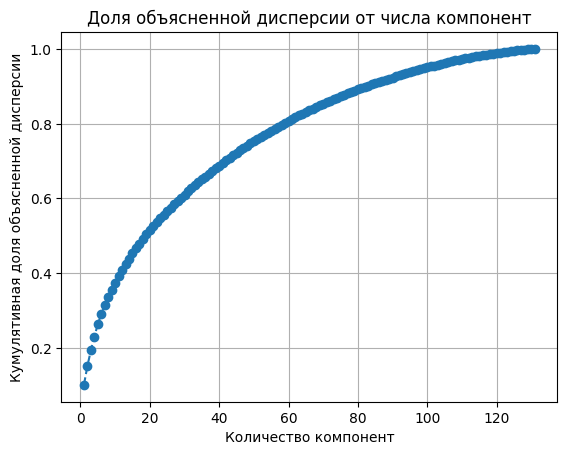

100


In [8]:
X_train, y_train, X_test, y_test = prepare_dataset('../data/balanced_data_80_20_new.parquet', 'scaler_80_20_new.joblib', 'pca_80_20_new.joblib')

Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'penalty':[None, 'elasticnet', 'l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10]}

log_model = LogisticRegression(random_state=42)
grid_search_clas = GridSearchCV(estimator=log_model, param_grid=parameters, cv=5, scoring='roc_auc')
grid_search_clas.fit(X_train, y_train)

# Лучшие параметры
best_params_clas = grid_search_clas.best_params_
best_log_model = grid_search_clas.best_estimator_
print(f'Best Hyperparameters: {best_params_clas}')
print(f'ROC AUC: {grid_search_clas.best_score_}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC: 0.7188602744798926


In [ ]:
best_log_model = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'liblinear', random_state=42)
make_test(best_log_model, X_train, y_train, X_test, y_test)
joblib.dump(best_log_model, 'best_logistic_regression_model_80_20.joblib')

ROC AUC: 0.5603142059334993
F1 Score: 0.23637911464245176
Recall: 0.1494170403587444
Precision: 0.5655125594025797


['best_logistic_regression_model_80_20.joblib']

Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None,5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}
forest_model = RandomForestClassifier(random_state=42)
grid_search_clas = GridSearchCV(estimator=forest_model, param_grid=parameters, cv=5, scoring='roc_auc', verbose=2)
grid_search_clas.fit(X_train_optimal_pca, y_train)

# Лучшие параметры
best_params_clas = grid_search_clas.best_params_
print(f'Best Hyperparameters: {best_params_clas}')
print(f'ROC AUC: {grid_search_clas.best_score_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=  11.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   9.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   9.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   9.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   9.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  23.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  23.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_est

In [ ]:
from sklearn.ensemble import RandomForestClassifier
test_tree_model = RandomForestClassifier(max_depth = 10, max_features=  'sqrt', min_samples_leaf = 4, min_samples_split = 2,  n_estimators = 100, random_state=42)
test_tree_model.fit(X_train, y_train)
joblib.dump(test_tree_model, 'best_tree_model_80_20.joblib')
predict = test_tree_model.predict(X_test)
get_metrics(y_test, predict)

ROC AUC: 0.5056035717909363
F1 Score: 0.02433862433862434
Recall: 0.012376681614349776
Precision: 0.7263157894736842


In [9]:
from sklearn.ensemble import RandomForestRegressor
parameters = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None,5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}
forest_model = RandomForestRegressor(random_state=42)
grid_search_clas = GridSearchCV(estimator=forest_model, param_grid=parameters, cv=3, scoring='roc_auc', verbose=2)
grid_search_clas.fit(X_train, y_train)

# Лучшие параметры
best_params_clas = grid_search_clas.best_params_
print(f'Best Hyperparameters: {best_params_clas}')
print(f'ROC AUC: {grid_search_clas.best_score_}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=  28.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=  27.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=  27.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.1min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

In [9]:
from sklearn.ensemble import RandomForestRegressor
test_tree_model = RandomForestRegressor(max_depth = 10, max_features=  'sqrt', min_samples_leaf = 4, min_samples_split = 5,  n_estimators = 100, random_state=42)
test_tree_model.fit(X_train, y_train)
joblib.dump(test_tree_model, 'best_tree_model_80_20_new.joblib')

['best_tree_model_80_20_new.joblib']

In [11]:
best_threshold = 0.5
best_f1_score = 0.0

for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    pred_binary = (pred >= threshold)
    f1 = roc_auc_score(y_test, pred_binary)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f"Best F1 Score: {best_f1_score} at threshold {best_threshold}")
pred_binary = (pred >= best_threshold)
get_metrics(y_test, pred_binary)

Best F1 Score: 0.6350872342644387 at threshold 0.2
ROC AUC: 0.6350872342644387
F1 Score: 0.4123806387882779
Recall: 0.5616143497757847
Precision: 0.3258064516129032
